In [1]:
import os
import warnings
from IPython.display import display, HTML
import platform
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
import random
from PreprocessFcns import *
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
# get all data and remove useless rows
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]

Xtrain = Xtrain.reset_index(drop= True)
for index, row in Xtrain.iterrows():
    if (row['Visit'] == '4 Weeks'):
        #print(row['Visit'])
        #print(Xtrain.loc[index, 'Visit'])
        #print(index)
        Xtrain.loc[index, 'Visit'] = '1 Month'
counter = 0
subjects = Xtrain['Subject'].unique()
features = pd.DataFrame()
for s in subjects:
    strain = Xtrain[Xtrain['Subject'] == s]
    visits = strain['Visit'].unique()
    # print(s.__str__() + ' visits: ' + visits)
    for v in visits:
        vtrain = strain[strain['Visit'] == v]
        mds = float('Nan')
        baseline_mds = float('Nan')
        
        try: 
            mds = int(summary_info.loc[(summary_info.VisitNm == v) & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            mds = float('Nan')
        try:
            baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            baseline_mds = float('Nan')
        if (np.isnan(mds) or np.isnan(baseline_mds)):
            #print(v + s.__str__())
            #counter += 1
            #display(vtrain)
            continue
        #display(vtrain)
        
        vtrain = vtrain.iloc[:, 5:-2]
        columns = vtrain.columns.values.tolist()

        for i in range(200):
        
            cols = ['Subject', 'MDS score', 'Visit', 'baseline MDS']
            vals = [s, mds, v, baseline_mds]
            for c in columns:
                cols.append(c + " mean")
                cols.append(c + " var")
                sample = vtrain[c].sample(frac = 0.1, replace = False)
                vals.append(sample.mean())
                vals.append(sample.var())
            
            df = pd.DataFrame(data = [vals], columns = cols)
            features = features.append(df, ignore_index = True)
        
for index, row in features.iterrows():
    if (row['Visit'] == '1 Month'):
        features.loc[index, 'Visit'] = 2
    elif (row['Visit'] == '2 Weeks: Time 0'):
        features.loc[index, 'Visit'] = 0
    elif (row['Visit'] == '2 Weeks: Time 60'):
        features.loc[index, 'Visit'] = 1
features

,Subject,MDS score,Visit,baseline MDS,RMSX mean,RMSX var,RMSY mean,RMSY var,RMSZ mean,RMSZ var,...,PSD_std mean,PSD_std var,PSD_skew mean,PSD_skew var,PSD_kur mean,PSD_kur var,jerk_mean mean,jerk_mean var,jerk_std mean,jerk_std var
0,1016,19,0,20,0.004319,0.000008,0.007764,0.000132,0.005307,0.000013,...,0.001721,3.954755e-06,3.690803,1.021002,17.914371,145.313309,2.199756e-04,2.245193e-07,0.063777,0.002648
1,1016,19,0,20,0.003455,0.000006,0.007870,0.000072,0.004676,0.000015,...,0.002309,1.364451e-05,3.911704,1.858116,14.114329,49.747389,9.558711e-06,4.164581e-07,0.057366,0.002548
2,1016,19,0,20,0.003986,0.000008,0.005434,0.000078,0.004468,0.000016,...,0.002020,1.424513e-05,3.658082,1.245375,14.347407,51.643931,-2.228325e-04,1.206019e-06,0.082366,0.003110
3,1016,19,0,20,0.005118,0.000008,0.004957,0.000018,0.005991,0.000055,...,0.000545,5.989444e-07,3.575874,0.911835,12.365582,76.006355,1.159007e-04,2.439171e-07,0.065978,0.002537
4,1016,19,0,20,0.002517,0.000008,0.006795,0.000068,0.003844,0.000005,...,0.001498,5.589582e-06,3.255943,1.242173,15.343312,133.227485,-8.186001e-05,1.525010e-07,0.055350,0.001841
5,1016,19,0,20,0.004069,0.000006,0.005598,0.000023,0.003675,0.000011,...,0.002631,1.270330e-05,2.897943,1.484187,13.514774,92.652125,-7.203696e-06,5.932952e-07,0.049727,0.001828
6,1016,19,0,20,0.004843,0.000008,0.003536,0.000011,0.004514,0.000011,...,0.001542,5.988929e-06,3.751448,1.175104,20.861469,62.666136,9.140043e-09,5.015979e-07,0.043218,0.001782
7,1016,19,0,20,0.002924,0.000009,0.007309,0.000130,0.008429,0.000122,...,0.001061,1.231520e-06,3.622790,1.560621,9.926045,35.859398,1.204600e-04,2.071852e-07,0.052141,0.001418
8,1016,19,0,20,0.004100,0.000007,0.003863,0.000021,0.003859,0.000010,...,0.000845,1.803798e-06,3.057675,1.462001,8.300019,11.614700,1.071468e-04,1.364966e-07,0.066850,0.001604
9,1016,19,0,20,0.004252,0.000007,0.007887,0.000072,0.003945,0.000009,...,0.002981,1.517406e-05,3.699239,0.991151,13.090974,41.595330,-1.104538e-04,1.393258e-07,0.039547,0.001301


In [3]:
### calculate first stack ###
a = []
b = []
v = []
subjs = []
pred_RFR = []
pred_NN = []
pred_LN = []
pred_LARS = []
pred_KNR = []

subjects = features['Subject'].unique()

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.neighbors import KNeighborsRegressor


for s in subjects:

    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 1000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    Xtrain = features[(features['Subject'] != s) & (features['Visit'] != 1)]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    

    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    Xtest = features[(features['Subject'] == s) & (features['Visit'] != 1)]
    
    actual = Xtest['MDS score'].values.astype(int)
    bmds = Xtest['baseline MDS'].values.astype(int)
    vis = Xtest['Visit'].values.astype(int)

    Xtest = Xtest.iloc[:, 4:].values
    

    if (len(Xtest) != 0):
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        v += list(vis)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))

stacked_predictions = pd.DataFrame()
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
# stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'visit', value = v)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LARS', value = pred_LARS)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)

stacked_predictions.style
stacked_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.008693,0.246136,-0.131300,0.204392,-0.052964,-0.055969,0.203623
actual mds,0.008693,1.000000,0.384480,0.142105,0.121887,0.153190,0.155959,0.086279
baseline mds,0.246136,0.384480,1.000000,0.045094,0.091824,0.078380,0.080424,0.117356
pred RFR,-0.131300,0.142105,0.045094,1.000000,0.671707,0.672834,0.672289,0.447008
pred NN,0.204392,0.121887,0.091824,0.671707,1.000000,0.635222,0.634715,0.582336
pred LN,-0.052964,0.153190,0.078380,0.672834,0.635222,1.000000,0.999666,0.500599
pred LARS,-0.055969,0.155959,0.080424,0.672289,0.634715,0.999666,1.000000,0.498742
pred KNR,0.203623,0.086279,0.117356,0.447008,0.582336,0.500599,0.498742,1.000000


In [4]:
### calculate second stack from first stack ###
second_stack_predictions_RFR = []
second_stack_predictions_NN = []
second_stack_predictions_LN = []
second_stack_predictions_LARS = []
second_stack_predictions_KNR = []
actual_mds = []
baseline_mds = []
subjs2 = []

clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

for s in stacked_predictions['subj'].unique():
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 2:].values
    stacked_test = stacked_test.iloc[:, 2:].values
    
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        
        subjs2 += [s for elem in list(stacked_ytest)]

second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
#second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.008693,-0.089513,0.032893,0.292040,0.292040,-0.159004
actual mds,0.008693,1.000000,0.016357,0.003380,0.030337,0.030337,0.034547
pred RFR,-0.089513,0.016357,1.000000,0.531615,0.498752,0.498752,0.577026
pred NN,0.032893,0.003380,0.531615,1.000000,0.729544,0.729544,0.704867
pred LN,0.292040,0.030337,0.498752,0.729544,1.000000,1.000000,0.428636
pred LARS,0.292040,0.030337,0.498752,0.729544,1.000000,1.000000,0.428636
pred KNR,-0.159004,0.034547,0.577026,0.704867,0.428636,0.428636,1.000000


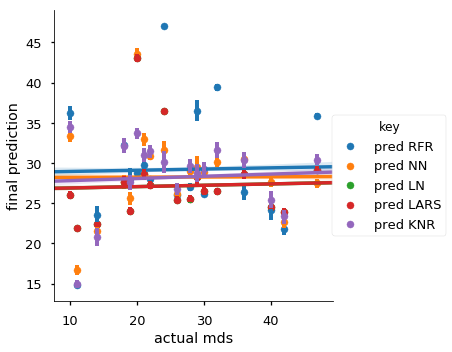

In [5]:
### calculate final predictions without second stack (from first stack only) ###
one_stack_predictions = pd.DataFrame()
for col in list(second_stack_predictions.columns.values)[2:]:
    df = pd.DataFrame()
    df['subj'] = second_stack_predictions['subj']
    df['actual mds'] = second_stack_predictions['actual mds']
    df['final prediction'] = second_stack_predictions[col]
    df['key'] = col
    one_stack_predictions = one_stack_predictions.append(df, ignore_index = True)

sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = one_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.016357366753666565
RMSE: 13.89439997409028


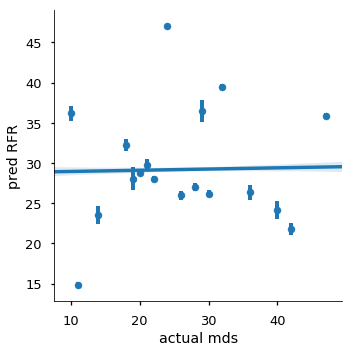

In [6]:
### 1 stack followed by RFR ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred RFR'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred RFR'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred RFR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.0033804128939193914
RMSE: 12.667986646621582


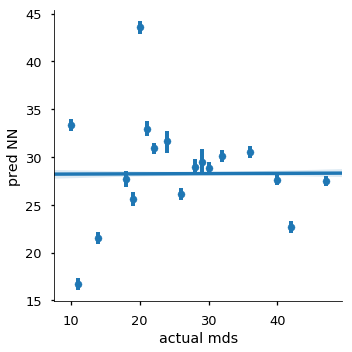

In [7]:
### 1 stack followed by NN ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred NN'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred NN'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred NN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.030337242345495674
RMSE: 11.409303204295554


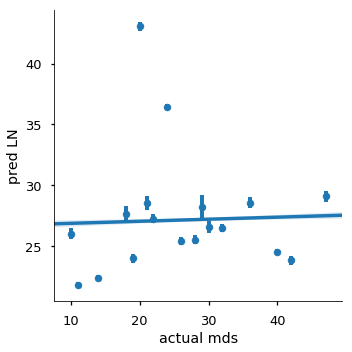

In [8]:
### 1 stack followed by LN ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LN'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LN'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred LN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.030337242345484183
RMSE: 11.409303204295602


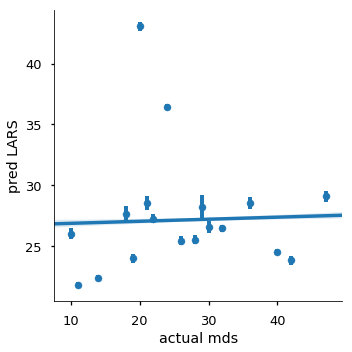

In [9]:
### 1 stack followed by LARS ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LARS'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LARS'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred LARS', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.03454675613975348
RMSE: 12.749852657746613


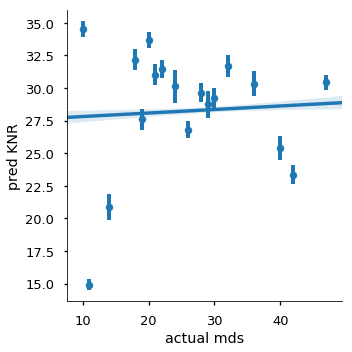

In [10]:
### 1 stack followed by KNR ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred KNR'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred KNR'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred KNR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [11]:
### calculate second stack from first stack - WITHOUT BASELINE ###
second_stack_predictions_RFR = []
second_stack_predictions_NN = []
second_stack_predictions_LN = []
second_stack_predictions_LARS = []
second_stack_predictions_KNR = []
actual_mds = []
baseline_mds = []
subjs2 = []

clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

for s in stacked_predictions['subj'].unique():
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 3:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        
        subjs2 += [s for elem in list(stacked_ytest)]

second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.008693,0.246136,-0.142641,-0.032610,0.005881,0.005881,-0.113896
actual mds,0.008693,1.000000,0.384480,0.068815,-0.008000,-0.189764,-0.189764,0.065958
baseline mds,0.246136,0.384480,1.000000,-0.086170,-0.018695,-0.076642,-0.076642,-0.054770
pred RFR,-0.142641,0.068815,-0.086170,1.000000,0.646303,0.376459,0.376459,0.798836
pred NN,-0.032610,-0.008000,-0.018695,0.646303,1.000000,0.809386,0.809386,0.612091
pred LN,0.005881,-0.189764,-0.076642,0.376459,0.809386,1.000000,1.000000,0.355379
pred LARS,0.005881,-0.189764,-0.076642,0.376459,0.809386,1.000000,1.000000,0.355379
pred KNR,-0.113896,0.065958,-0.054770,0.798836,0.612091,0.355379,0.355379,1.000000


,subj,actual mds,final prediction
subj,1.000000,0.008693,0.034953
actual mds,0.008693,1.000000,0.033217
final prediction,0.034953,0.033217,1.000000


num data points: 5000
correlation coefficient: 0.033216561248901794
RMSE: 13.534638888422549


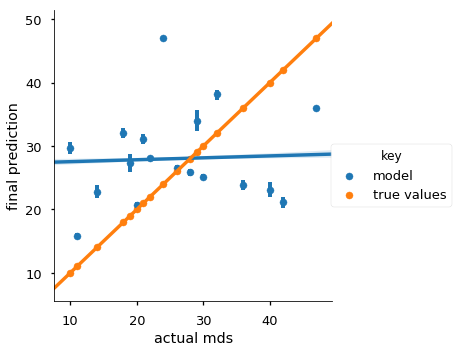

,subj,actual mds,final prediction
subj,1.000000,0.008693,-0.044601
actual mds,0.008693,1.000000,0.251834
final prediction,-0.044601,0.251834,1.000000


num data points: 5000
correlation coefficient: 0.25183364252760293
RMSE: 10.195479868355143


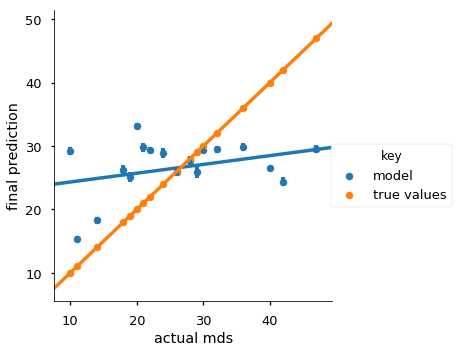

,subj,actual mds,final prediction
subj,1.000000,0.008693,0.276767
actual mds,0.008693,1.000000,0.241250
final prediction,0.276767,0.241250,1.000000


num data points: 5000
correlation coefficient: 0.241249846478495
RMSE: 10.264226926568847


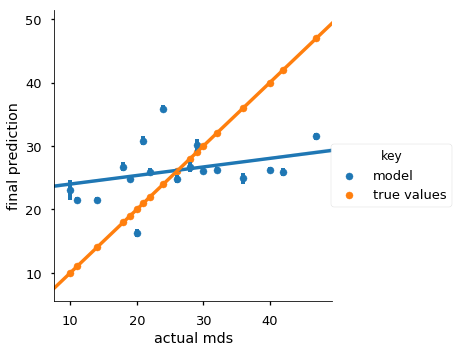

,subj,actual mds,final prediction
subj,1.000000,0.008693,0.241535
actual mds,0.008693,1.000000,0.271054
final prediction,0.241535,0.271054,1.000000


num data points: 5000
correlation coefficient: 0.2710538190058593
RMSE: 9.980707082968168


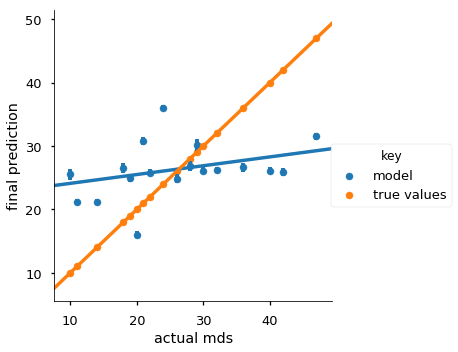

,subj,actual mds,final prediction
subj,1.000000,0.008693,-0.045950
actual mds,0.008693,1.000000,0.061789
final prediction,-0.045950,0.061789,1.000000


num data points: 5000
correlation coefficient: 0.061789404311589115
RMSE: 12.076236563406068


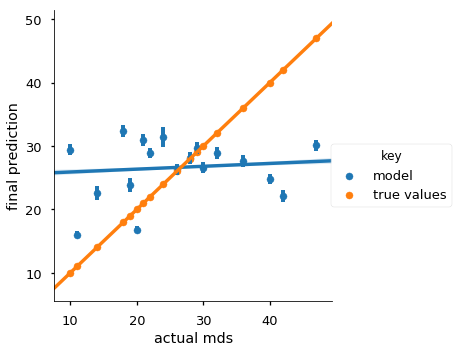

In [12]:
### calculate final predictions from second stack ###
clfs = [RandomForestRegressor(n_estimators=50, random_state = 2), MLPRegressor(max_iter = 10000, random_state = 2), 
        LinearRegression(), Lars(eps = 2.220446049250313e-7), KNeighborsRegressor(weights = 'distance')]

for clf_final in clfs:

    actual_mds = []
    predictions_final = []
    subjs3 = []
    
    for s in second_stack_predictions['subj'].unique():

        
        second_stack_train = second_stack_predictions[second_stack_predictions.subj != s]
        second_stack_test = second_stack_predictions[second_stack_predictions.subj == s]
        second_stack_ytrain = second_stack_train['actual mds'].values.astype(int)
        second_stack_ytest = second_stack_test['actual mds'].values.astype(int)
        second_stack_train = second_stack_train.iloc[:, 2:].values
        second_stack_test = second_stack_test.iloc[:, 2:].values
    
        scaler = StandardScaler() 
        scaler.fit(second_stack_train)  
        second_stack_std = scaler.transform(second_stack_train)
        second_stack_test_std = scaler.transform(second_stack_test)
    
        clf_final.fit(second_stack_train, second_stack_ytrain)
    
        if (len(second_stack_test) != 0):
            actual_mds += list(second_stack_ytest)
            predictions_final += list(clf_final.predict(second_stack_test))
            subjs3 += [s for elem in list(second_stack_ytest)]

    predictions = pd.DataFrame()
    predictions.insert(loc = len(predictions.columns.values), column = 'subj', value = np.array(subjs3))
    predictions.insert(loc = len(predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
    predictions.insert(loc = len(predictions.columns.values), column = 'final prediction', value = np.array(predictions_final))
    display(predictions.corr())
    
    predictions['key'] = 'model'
    actual_for_comp = pd.DataFrame()
    actual_for_comp['subj'] = predictions['subj']
    actual_for_comp['actual mds'] = predictions['actual mds']
    actual_for_comp['final prediction'] = predictions['actual mds']
    actual_for_comp['key'] = 'true values'

    #print('excluding datapoints with the highest and lowest actual MDS scores')
    #predictions = predictions[(predictions['actual mds'] > 10) & (predictions['actual mds'] < 30)]
    print("num data points: " + len(predictions.index.values).__str__())

    print('correlation coefficient: ' + np.corrcoef(predictions['final prediction'], predictions['actual mds'])[0][1].__str__())
    print('RMSE: ' + float(np.sqrt(np.mean((np.array(predictions['final prediction']) - predictions['actual mds'])**2))).__str__()) 
    
    df_display = predictions.append(actual_for_comp, ignore_index = True)
    #display(df_display)
    sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = df_display, order = 1, x_estimator=np.mean)
    plt.show()